In [5]:
# 基础模块
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from datetime import datetime
from collections import defaultdict

# 可视化配置
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'STHeiti'         # 中文支持（macOS）
plt.rcParams['axes.unicode_minus'] = False      # 正负号支持
%matplotlib inline

# 轨迹聚类与建模
from sklearn.cluster import DBSCAN
from pyproj import Transformer

# API调用（如POI增强）
import requests
import time
import json

# Neo4j 图数据库
from py2neo import Graph, Node, Relationship  # 若报错先注释，等后面阶段再装


# 路径配置
base_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前脚本所在目录
root_dir = os.path.abspath(os.path.join(base_dir, '..'))  # 项目根目录
output_dir = os.path.join(root_dir, 'outputs')
traj_path = os.path.join(output_dir, 'geolife_cleaned_traj.csv')

已加载轨迹点数: 212806


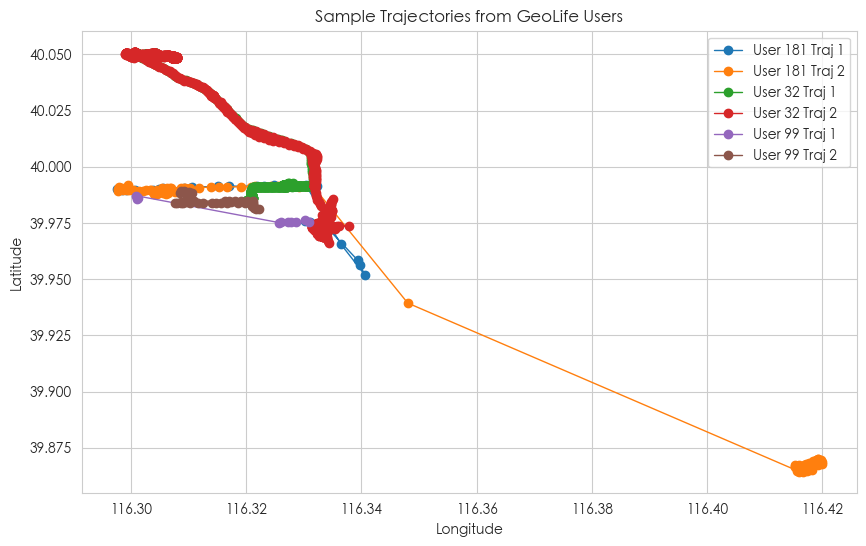

In [3]:
# ==========================================
# Trajectory Mining Based on GeoLife Dataset
# Stage 1: Load & Preview Cleaned Trajectory
# ==========================================

# 路径配置
base_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前脚本所在目录
root_dir = os.path.abspath(os.path.join(base_dir, '..'))  # 项目根目录
output_dir = os.path.join(root_dir, 'outputs')
traj_path = os.path.join(output_dir, 'geolife_cleaned_traj.csv')

df = pd.read_csv(traj_path)
df['t'] = pd.to_datetime(df['t'])  # 转换时间格式
print("已加载轨迹点数:", len(df))
df.head()

# 可视化前几条轨迹
def plot_sample_trajectories(df, num_users=3):
    plt.figure(figsize=(10, 6))
    users = df['uid'].unique()[:num_users]
    for uid in users:
        sub = df[df['uid'] == uid]
        for tid in sub['traj_id'].unique()[:2]:
            traj = sub[sub['traj_id'] == tid]
            plt.plot(traj['x'], traj['y'], marker='o', linewidth=1, label=f"User {uid} Traj {tid}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Sample Trajectories from GeoLife Users")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sample_trajectories(df)

In [13]:
def clustering_summary(eps_list, min_samples_list):
    coords = df[['x', 'y']].values
    results = defaultdict(list)
    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms).fit(coords)
            labels = model.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            results['eps'].append(eps)
            results['min_samples'].append(ms)
            results['n_clusters'].append(n_clusters)
            results['n_noise'].append(n_noise)
    return pd.DataFrame(results)

param_grid = clustering_summary(eps_list=[0.0006, 0.0008, 0.001], min_samples_list=[8, 10, 12])
param_grid.sort_values(by='n_clusters', ascending=False)

,eps,min_samples,n_clusters,n_noise
0,0.0006,8,469,27939
1,0.0006,10,423,31862
2,0.0006,12,417,34457
3,0.0008,8,411,20508
4,0.0008,10,375,25860
7,0.0010,10,348,20132
5,0.0008,12,336,29347
8,0.0010,12,331,24246
6,0.0010,8,289,16082


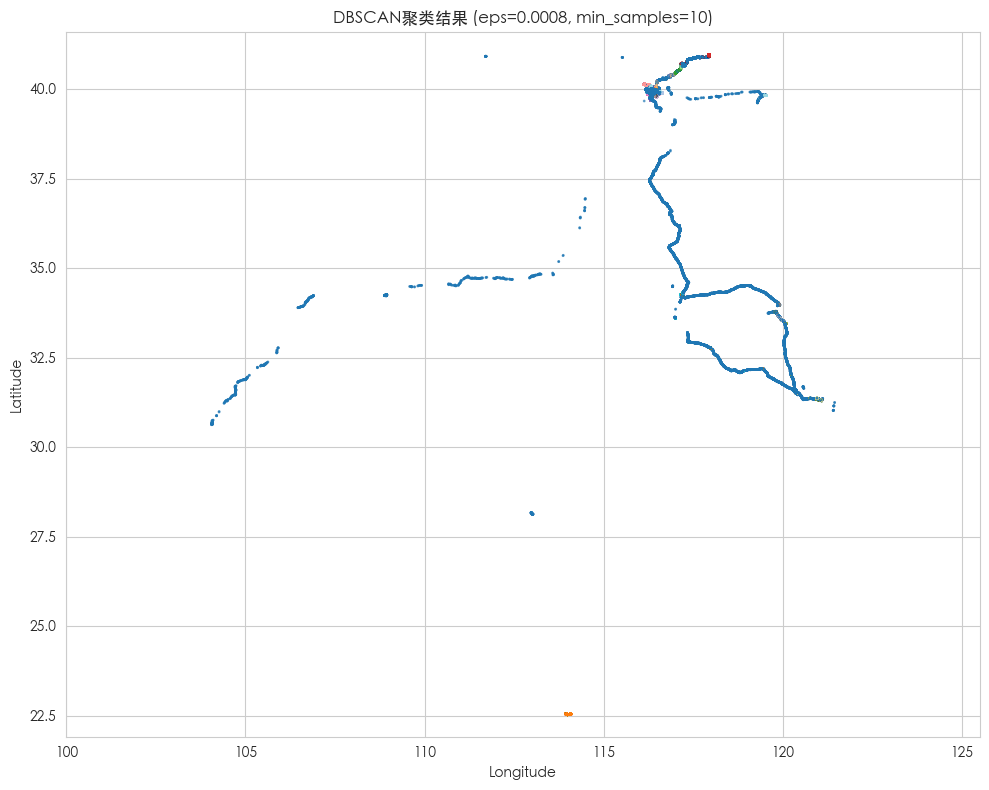

In [4]:
traj_df = pd.read_csv(traj_path)
coords = traj_df[["x", "y"]].values

# 聚类参数（基于测试最优参数）
eps = 0.0008
min_samples = 10

model = DBSCAN(eps=eps, min_samples=min_samples)
labels = model.fit_predict(coords)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c=labels, s=1, cmap='tab20', alpha=0.6)
plt.title(f'DBSCAN聚类结果 (eps={eps}, min_samples={min_samples})')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()